In [2]:
import pandas as pd
import numpy as np

from modules.utils.utils import read_json , initialize_tables_in_db, load_to_postgres, build_connection_engine
from pathlib import Path
import matplotlib.pyplot as plt

p = Path(".")

config = read_json(p / "modules"/"config.json")
table_schema = 'remote'


# 1 - Load raw data

In [2]:
sheets = pd.ExcelFile('Data Analyst Assignment.xlsx')

In [3]:
# here we load the data from the sheets into pandas DF
# this will generate a dictionary that maps all the sheets
dct = pd.read_excel(sheets, sheet_name=None)
        

# 2 - Load raw data in staging tables in Postgres DB

Here I want to 
1. Load all the raw data into postgres into the public.table schema. This will be our raw/stagin section
2. Once all the data is loaded, I can perform the EDA and evaluate how to normalize the table to account for missing data, bad data

In [4]:
for key in dct:
    print(len(dct[key]))

99
18484
569
11
3
39409
60855


In [46]:
for key in dct:
    table_name = config.get("DATABASE").get("TABLES").get(key)
    df = dct[key]
    print(table_name)
    initialize_tables_in_db(config, df, table_schema, table_name)
    load_to_postgres(config, df, table_schema, table_name)

dimaccounts
False
Initializing table
Inserted 99 rows in remote.dimaccounts
dimcustomer
False
Initializing table
Inserted 18484 rows in remote.dimcustomer
dimproduct
False
Initializing table
Inserted 569 rows in remote.dimproduct
dimsalesterritory
False
Initializing table
Inserted 11 rows in remote.dimsalesterritory
dimscenario
False
Initializing table
Inserted 3 rows in remote.dimscenario
factfinance
False
Initializing table
Inserted 39409 rows in remote.factfinance
factresellersales
False
Initializing table
Inserted 60855 rows in remote.factresellersales


# 3 - Perform EDA on the raw data

### EDA on DimAccounts

In [4]:
p = Path(".")

config = read_json(p / "modules"/"config.json")
conn_s = build_connection_engine(config, 's')

In [48]:
def count_and_surface_duplicates(df):
    """
    """
    dup_cnt = df.duplicated().sum()
    duplicates = df.loc[df.duplicated(), :]

    print(f"the dataframe has {dup_cnt} duplicated rows.'")

    return duplicates, dup_cnt


def check_for_date_consistency():
    return True

In [49]:


for key in dct:
    table_name = config.get("DATABASE").get("TABLES").get(key).lower()+'_corrupted_data_logger'
    df = dct[key]
    print(table_name)
    dups, dup_cnt = count_and_surface_duplicates(df)
    if dup_cnt > 0 :
        dups['error_type'] = 'duplicated_row_in_raw_table'
        initialize_tables_in_db(config, df, table_schema, table_name)
        load_to_postgres(config, df, table_schema, table_name)

dimaccounts_corrupted_data_logger
the dataframe has 0 duplicated rows.'
dimcustomer_corrupted_data_logger
the dataframe has 0 duplicated rows.'
dimproduct_corrupted_data_logger
the dataframe has 0 duplicated rows.'
dimsalesterritory_corrupted_data_logger
the dataframe has 0 duplicated rows.'
dimscenario_corrupted_data_logger
the dataframe has 0 duplicated rows.'
factfinance_corrupted_data_logger
the dataframe has 0 duplicated rows.'
factresellersales_corrupted_data_logger
the dataframe has 0 duplicated rows.'


# issues 

- dimaccounts -> potentially faulty custommembers 
- dimcustomer -> birthdate, datefirstpurchase, phone number (strip)

In [8]:
conn_s = build_connection_engine(config, 's')

### EDA on dimaccounts

In [8]:
dimaccounts = pd.read_sql_query(f"select * from remote.dimaccounts ",con=conn_s)

df = dimaccounts.copy()

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   accountkey                     99 non-null     float64
 1   parentaccountkey               96 non-null     float64
 2   accountcodealternatekey        99 non-null     float64
 3   parentaccountcodealternatekey  96 non-null     float64
 4   accountdescription             99 non-null     object 
 5   accounttype                    98 non-null     object 
 6   operator                       99 non-null     object 
 7   custommembers                  1 non-null      object 
 8   valuetype                      99 non-null     object 
 9   custommemberoptions            0 non-null      object 
dtypes: float64(4), object(6)
memory usage: 7.9+ KB


In [11]:
df.describe()

,accountkey,parentaccountkey,accountcodealternatekey,parentaccountcodealternatekey
count,99.000000,96.000000,99.000000,96.000000
mean,51.000000,44.114583,3679.919192,1383.479167
std,29.172254,27.476639,2883.785277,2105.738645
min,1.000000,1.000000,1.000000,1.000000
25%,26.500000,25.000000,1168.000000,80.000000
50%,51.000000,47.500000,2430.000000,620.000000
75%,75.500000,60.250000,6270.000000,2200.000000
max,101.000000,95.000000,9540.000000,9500.000000


In [12]:
df


,accountkey,parentaccountkey,accountcodealternatekey,parentaccountcodealternatekey,accountdescription,accounttype,operator,custommembers,valuetype,custommemberoptions
0,1.0,NaN,1.0,NaN,Balance Sheet,None,~,None,Currency,None
1,2.0,1.0,10.0,1.0,Assets,Assets,+,None,Currency,None
2,3.0,2.0,110.0,10.0,Current Assets,Assets,+,None,Currency,None
3,4.0,3.0,1110.0,110.0,Cash,Assets,+,None,Currency,None
4,5.0,3.0,1120.0,110.0,Receivables,Assets,+,None,Currency,None
...,...,...,...,...,...,...,...,...,...,...
94,97.0,95.0,9520.0,9500.0,Units,Flow,~,None,Units,None
95,98.0,95.0,9530.0,9500.0,Average Unit Price,Balances,~,[Account].[Accounts].[Account Level 04].&[50]/...,Currency,None
96,99.0,95.0,9540.0,9500.0,Square Footage,Balances,~,None,Units,None
97,100.0,27.0,2220.0,2200.0,Current Installments of Long-term Debt,Liabilities,+,None,Currency,None


In [15]:
df.operator.unique()

array(['~', '+', '-'], dtype=object)

In [22]:
df[df['custommembers'].notna()]

,accountkey,parentaccountkey,accountcodealternatekey,parentaccountcodealternatekey,accountdescription,accounttype,operator,custommembers,valuetype,custommemberoptions
95,98.0,95.0,9530.0,9500.0,Average Unit Price,Balances,~,[Account].[Accounts].[Account Level 04].&[50]/...,Currency,None


## EDA on DimCustomer

In [9]:
dimcustomer = pd.read_sql_query(f"select * from remote.dimcustomer ",con=conn_s)

df = dimcustomer.copy()

In [172]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18484 entries, 0 to 18483
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CustomerKey           18484 non-null  float64
 1   GeographyKey          18484 non-null  float64
 2   CustomerAlternateKey  18484 non-null  object 
 3   Title                 101 non-null    object 
 4   FirstName             18484 non-null  object 
 5   MiddleName            10654 non-null  object 
 6   LastName              18484 non-null  object 
 7   NameStyle             18484 non-null  float64
 8   BirthDate             18484 non-null  object 
 9   MaritalStatus         18484 non-null  object 
 10  Suffix                3 non-null      object 
 11  Gender                18484 non-null  object 
 12  EmailAddress          18484 non-null  object 
 13  YearlyIncome          18484 non-null  float64
 14  TotalChildren         18484 non-null  float64
 15  NumberChildrenAtHom

In [82]:
df.head(10)

,CustomerKey,GeographyKey,CustomerAlternateKey,Title,FirstName,MiddleName,LastName,NameStyle,BirthDate,MaritalStatus,...,EnglishOccupation,SpanishOccupation,FrenchOccupation,HouseOwnerFlag,NumberCarsOwned,AddressLine1,AddressLine2,Phone,DateFirstPurchase,CommuteDistance
0,11000.0,26.0,AW00011000,None,Jon,V,Yang,0.0,1971-06-10 00:00:00,M,...,Professional,Profesional,Cadre,1.0,0.0,3761 N. 14th St,None,1 (11) 500 555-0162,19/01/11,1-2 Miles
1,11001.0,37.0,AW00011001,None,Eugene,L,Huang,0.0,1976-10-05 00:00:00,S,...,Professional,Profesional,Cadre,0.0,1.0,2243 W St.,None,1 (11) 500 555-0110,15/01/11,0-1 Miles
2,11002.0,31.0,AW00011002,None,Ruben,None,Torres,0.0,1971-09-02 00:00:00,M,...,Professional,Profesional,Cadre,1.0,1.0,5844 Linden Land,None,1 (11) 500 555-0184,2011-07-01 00:00:00,2-5 Miles
3,11003.0,11.0,AW00011003,None,Christy,None,Zhu,0.0,14/08/73,S,...,Professional,Profesional,Cadre,0.0,1.0,1825 Village Pl.,None,1 (11) 500 555-0162,29/12/10,5-10 Miles
4,11004.0,19.0,AW00011004,None,Elizabeth,None,Johnson,0.0,1979-05-08 00:00:00,S,...,Professional,Profesional,Cadre,1.0,4.0,7553 Harness Circle,None,1 (11) 500 555-0131,23/01/11,1-2 Miles
5,11005.0,22.0,AW00011005,None,Julio,None,Ruiz,0.0,1976-01-08 00:00:00,S,...,Professional,Profesional,Cadre,1.0,1.0,7305 Humphrey Drive,None,1 (11) 500 555-0151,30/12/10,5-10 Miles
6,11006.0,8.0,AW00011006,None,Janet,G,Alvarez,0.0,1976-02-12 00:00:00,S,...,Professional,Profesional,Cadre,1.0,1.0,2612 Berry Dr,None,1 (11) 500 555-0184,24/01/11,5-10 Miles
7,11007.0,40.0,AW00011007,None,Marco,None,Mehta,0.0,1969-06-11 00:00:00,M,...,Professional,Profesional,Cadre,1.0,2.0,942 Brook Street,None,1 (11) 500 555-0126,2011-09-01 00:00:00,0-1 Miles
8,11008.0,32.0,AW00011008,None,Rob,None,Verhoff,0.0,1975-04-07 00:00:00,S,...,Professional,Profesional,Cadre,1.0,3.0,624 Peabody Road,None,1 (11) 500 555-0164,25/01/11,10+ Miles
9,11009.0,25.0,AW00011009,None,Shannon,C,Carlson,0.0,29/09/69,S,...,Professional,Profesional,Cadre,0.0,1.0,3839 Northgate Road,None,1 (11) 500 555-0110,27/01/11,5-10 Miles


/var/folders/c2/pkzg7ljn0jb73c5wmvht_8ch0000gn/T/ipykernel_27696/2497868187.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_exploration['tmp_date'] = tmp
/var/folders/c2/pkzg7ljn0jb73c5wmvht_8ch0000gn/T/ipykernel_27696/2497868187.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_exploration['year'] = date_exploration.tmp_date.dt.year


Text(0.5, 1.0, '19')

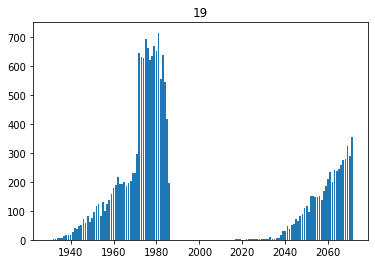

In [157]:
# birth date exploration

tmp = []
for ix, row in df.iterrows():
    if len(row['BirthDate']) > 8:
        tmp.append(pd.to_datetime(row['BirthDate'], infer_datetime_format=True))
    else:
        tmp.append(pd.to_datetime(row['BirthDate'], infer_datetime_format=True, errors='coerce'))

date_exploration = df[['CustomerKey', 'BirthDate']]
date_exploration['tmp_date'] = tmp
date_exploration['year'] = date_exploration.tmp_date.dt.year

img = date_exploration.groupby('year', as_index = False)['CustomerKey'].count()

plt.bar(img.year, img.CustomerKey)
plt.title(str(date_exploration['year'].median())[:2])


/var/folders/c2/pkzg7ljn0jb73c5wmvht_8ch0000gn/T/ipykernel_27696/1169386276.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_exploration['tmp_date'] = tmp
/var/folders/c2/pkzg7ljn0jb73c5wmvht_8ch0000gn/T/ipykernel_27696/1169386276.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_exploration['year'] = date_exploration.tmp_date.dt.year


<BarContainer object of 5 artists>

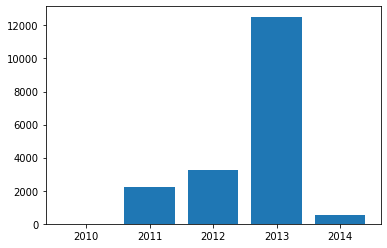

In [121]:
# First Sale date exploration

tmp = []
for ix, row in df.iterrows():
    if len(row['DateFirstPurchase']) > 8:
        tmp.append(pd.to_datetime(row['DateFirstPurchase'], infer_datetime_format=True))
    else:
        tmp.append(pd.to_datetime(row['DateFirstPurchase'], infer_datetime_format=True, errors='coerce'))

date_exploration = df[['CustomerKey', 'DateFirstPurchase']]
date_exploration['tmp_date'] = tmp
date_exploration['year'] = date_exploration.tmp_date.dt.year

img = date_exploration.groupby('year', as_index = False)['CustomerKey'].count()

plt.bar(img.year, img.CustomerKey)


array(['1971-06-10 00:00:00', '1976-10-05 00:00:00',
       '1971-09-02 00:00:00', '14/08/73', '1979-05-08 00:00:00',
       '1976-01-08 00:00:00'], dtype=object)

In [6]:
col = 'BirthDate'
key_col = 'CustomerKey'
def transfrom_date(df, col, key_col):
    """
    This function is based on the analysis conducted on the table DimCustomers. It generates a new column, optimized_BirthDate which imputes the median values of the BirthDates seen in the data to try solve data corruption in those dates that have a format nn/nn/nn without an expicit year
    """
    tmp = []
    for ix, row in df.iterrows():
        if len(row[col]) > 8:
            tmp.append(pd.to_datetime(row[col], infer_datetime_format=True))
        else:
            tmp.append(pd.to_datetime(row[col], infer_datetime_format=True, errors='coerce'))

    date_exploration = df[[key_col, col]]
    date_exploration['tmp_date'] = tmp
    date_exploration['year'] = date_exploration.tmp_date.dt.year
    df[f'{col}_flag'] = np.where(df[col].str.len() > 8, 0, 1)

    df[f'{col}_left'] = df[col].str[:6]
    df[f'{col}_right'] = df[col].str[6:]
    df[f'optimized_{col}'] = np.where(df[f'{col}_flag'] == 0,  df[col], df[f'{col}_left']+str(date_exploration['year'].median())[:2]+df[f'{col}_right'])

    return df

In [7]:
df = transfrom_date(df, col, key_col)

/var/folders/c2/pkzg7ljn0jb73c5wmvht_8ch0000gn/T/ipykernel_38816/2911446197.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_exploration['tmp_date'] = tmp
/var/folders/c2/pkzg7ljn0jb73c5wmvht_8ch0000gn/T/ipykernel_38816/2911446197.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_exploration['year'] = date_exploration.tmp_date.dt.year


In [176]:
col = 'DateFirstPurchase'
key_col = 'CustomerKey'
df = transfrom_date(df, col, key_col)


/var/folders/c2/pkzg7ljn0jb73c5wmvht_8ch0000gn/T/ipykernel_27696/2911446197.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_exploration['tmp_date'] = tmp
/var/folders/c2/pkzg7ljn0jb73c5wmvht_8ch0000gn/T/ipykernel_27696/2911446197.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_exploration['year'] = date_exploration.tmp_date.dt.year


In [181]:
df['BirthDate'] = pd.to_datetime(df['optimized_BirthDate'], infer_datetime_format=True)
df['DateFirstPurchase'] = pd.to_datetime(df['optimized_DateFirstPurchase'], infer_datetime_format=True)

    

In [20]:
df.Phone.str.replace('(', '').str.replace(')', '').str.replace('-', '').str.replace(' ', '').astype(int)

/var/folders/c2/pkzg7ljn0jb73c5wmvht_8ch0000gn/T/ipykernel_38816/619748776.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.Phone.str.replace('(', '').str.replace(')', '').str.replace('-', '').str.replace(' ', '').astype(int)


0        1115005550162
1        1115005550110
2        1115005550184
3        1115005550162
4        1115005550131
             ...      
18479    1115005550136
18480    1115005550146
18481    1115005550144
18482    1115005550137
18483    1115005550141
Name: Phone, Length: 18484, dtype: int64

# Prototyping data check pipe

In [53]:
for key in dct:
    table_name = config.get("DATABASE").get("TABLES").get(
        key).lower()+'_corrupted_data_logger'
    if key == "DimAccounts":
        df = dct[key]
        print(table_name)
        # Common error checks for all the tables
        dups, dup_cnt = count_and_surface_duplicates(df)

        # Table specific checks generated through EDAs
        data_error = df[df['CustomMembers'].notna()]
        data_error['error_type'] = 'potential_data_corruption'

        tmp = [dups, data_error]

        df = pd.concat(tmp)

        initialize_tables_in_db(config, df, table_schema, table_name)
        load_to_postgres(config, df, table_schema, table_name)

    if key == "DimCustomer":
        df = dct[key]
        print(table_name)
        # Common error checks for all the tables
        dups, dup_cnt = count_and_surface_duplicates(df)

        # Table specific checks generated through EDAs
        ## date transform 
        cols = ['BirthDate', 'DateFirstPurchase']
        key_col = 'CustomerKey'
        for col in cols:
            df = transfrom_date(df, col, key_col)
        df = df[(df['BirthDate_flag'] == 1) | (df['DateFirstPurchase_flag'] == 1) ]
        df['error_type'] = 'date_inconcistency'


        initialize_tables_in_db(config, df, table_schema, table_name)
        load_to_postgres(config, df, table_schema, table_name)

dimaccounts_corrupted_data_logger
the dataframe has 0 duplicated rows.'


/var/folders/c2/pkzg7ljn0jb73c5wmvht_8ch0000gn/T/ipykernel_27696/4137533852.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_error['erro_type'] = 'potential_data_corruption'


False
Initializing table
Inserted 1 rows in remote.dimaccounts_corrupted_data_logger
